# =================================
# Airbnb price prediction modelling
# =================================

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib  

import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')

# =========================
# Step 1: Load Data
# =========================

In [2]:
bnb = pd.read_csv(r"C:\Users\cheru\Downloads\AB_NYC_2019.csv")
bnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
# Basic info
print("Data Shape:")
print(bnb.shape)
print("Data Info:")
print(bnb.info())
print("\nData Description:")
print(bnb.describe(include='all'))


Data Shape:
(48895, 16)
Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 1

# =======================================
# Step 2: Exploratory Data Analysis (EDA)
# =======================================

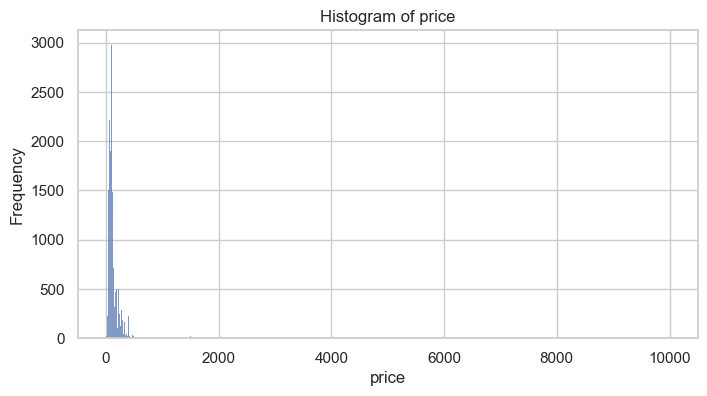

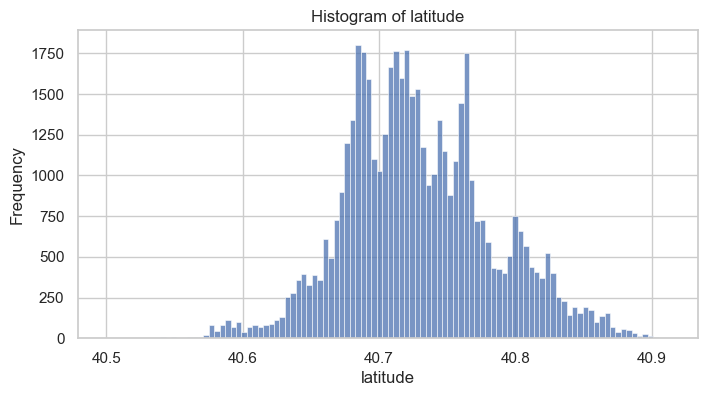

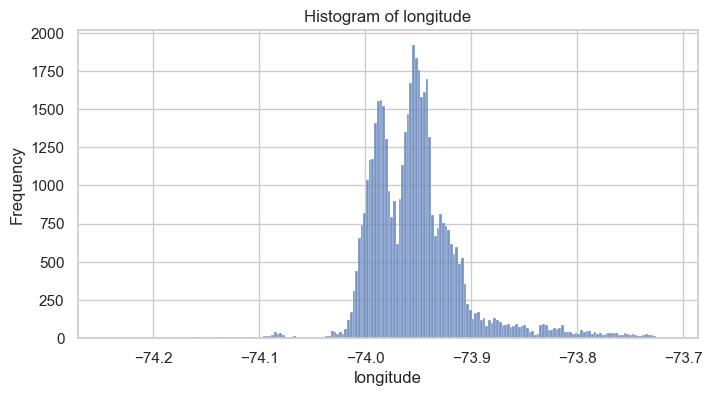

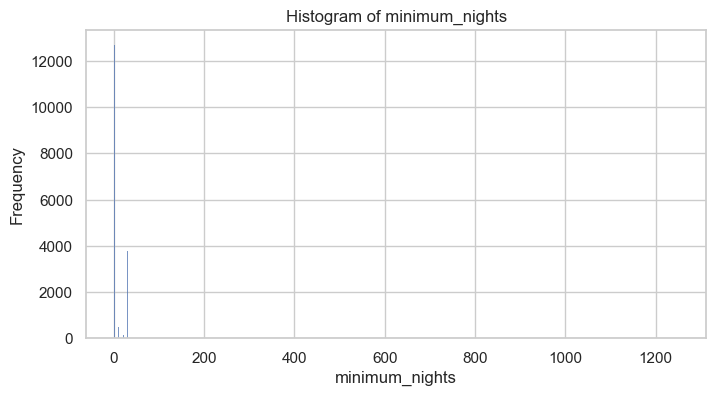

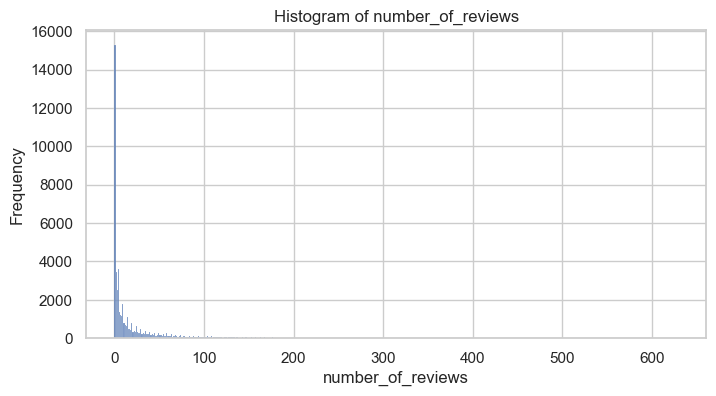

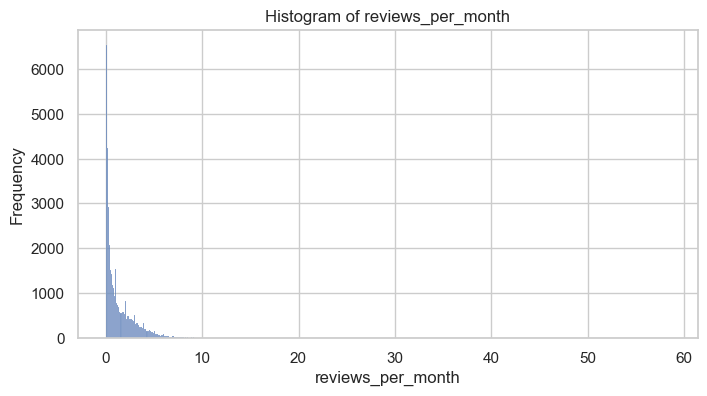

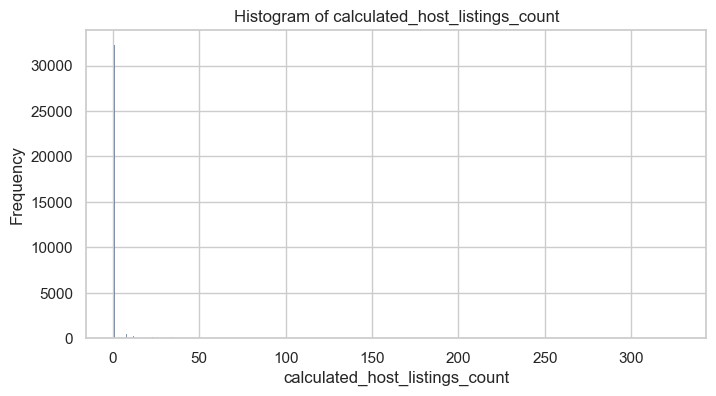

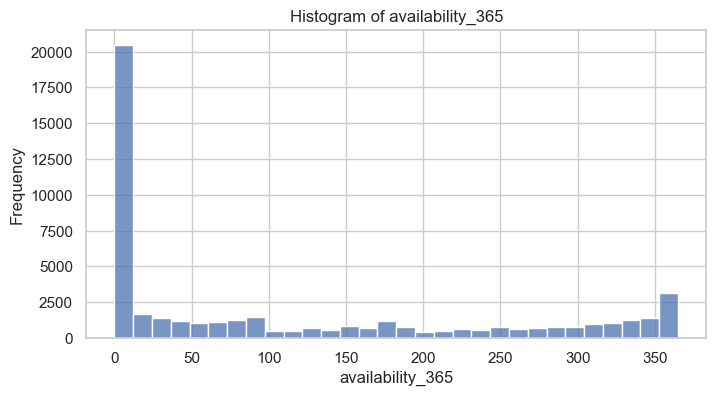

In [4]:
num_cols = [
    'price',
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(bnb[col], kde=False)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

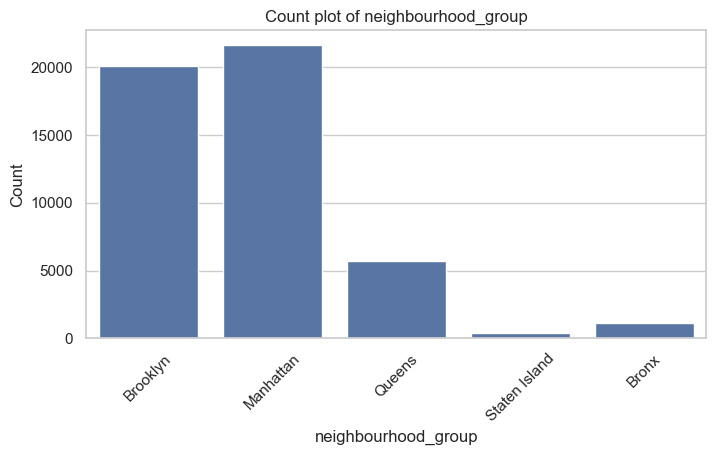

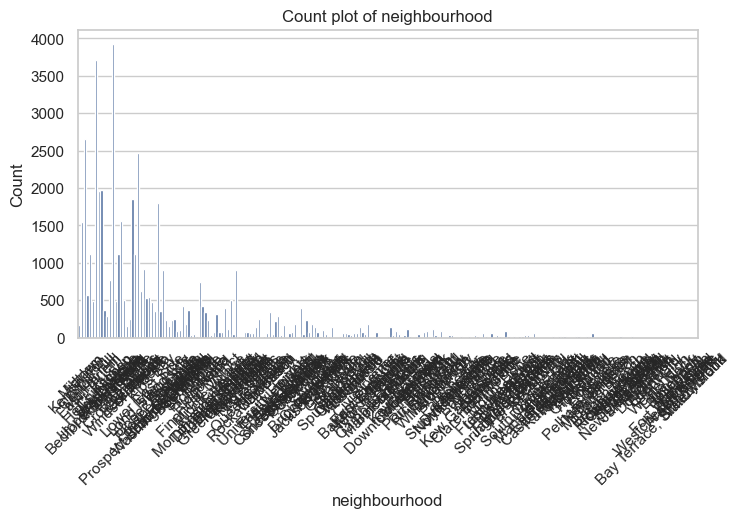

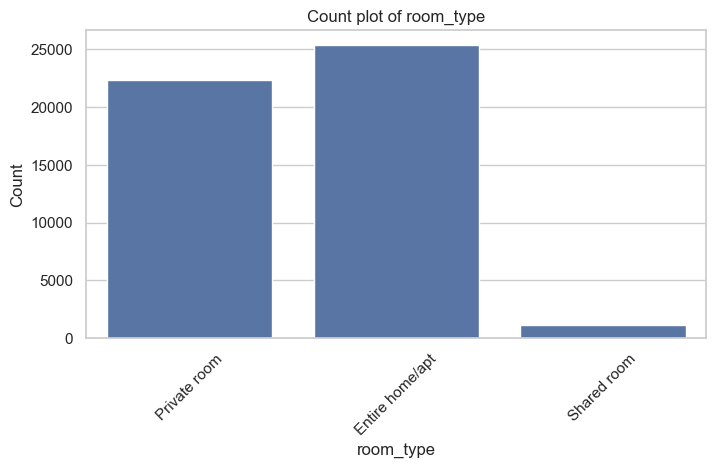

In [5]:
categorical_cols = [
    'neighbourhood_group','neighbourhood','room_type'
]

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=bnb[col])
    plt.title(f'Count plot of {col}')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.show()

In [6]:
bnb['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

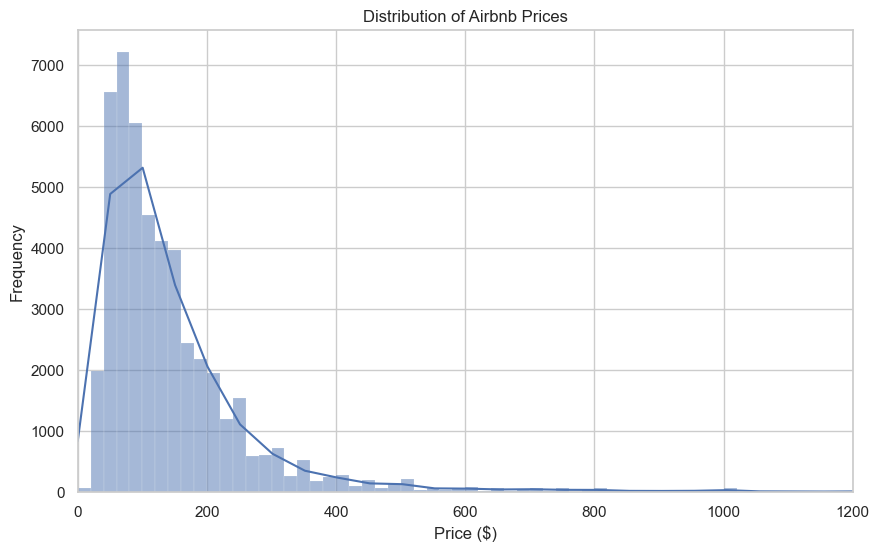

In [7]:
# Histogram of Prices
plt.figure(figsize=(10,6))
sns.histplot(bnb['price'], bins=500, kde=True)
plt.title('Distribution of Airbnb Prices')
plt.xlim(0, 1200)
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()



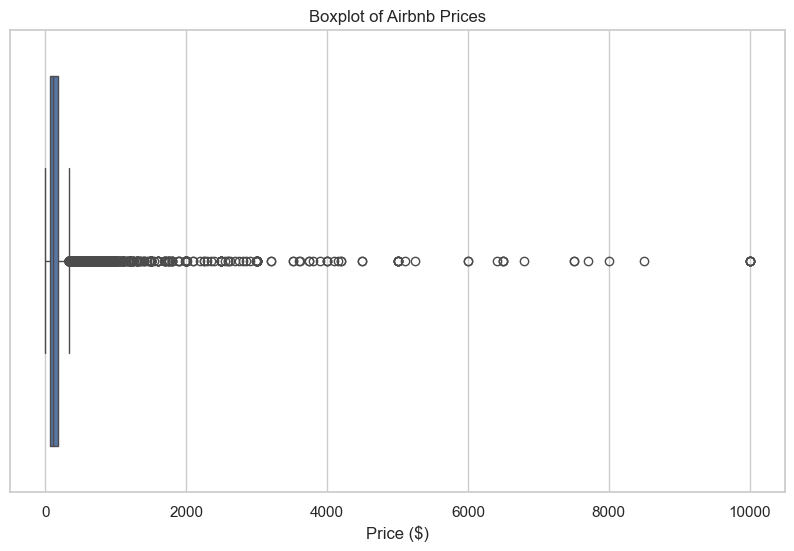

In [8]:
# Boxplot to detect outliers
plt.figure(figsize=(10,6))
sns.boxplot(x=bnb['price'])
plt.title('Boxplot of Airbnb Prices')
plt.xlabel('Price ($)')
plt.show()

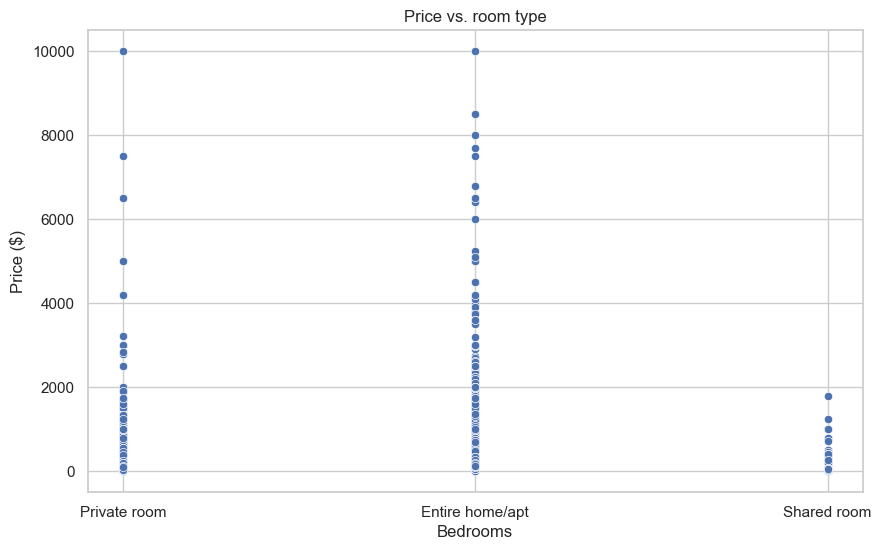

In [9]:
# Price vs. room type scatterplot
plt.figure(figsize=(10,6))
sns.scatterplot(x='room_type', y='price', data=bnb)
plt.title('Price vs. room type')
plt.xlabel('Bedrooms')
plt.ylabel('Price ($)')
plt.show()

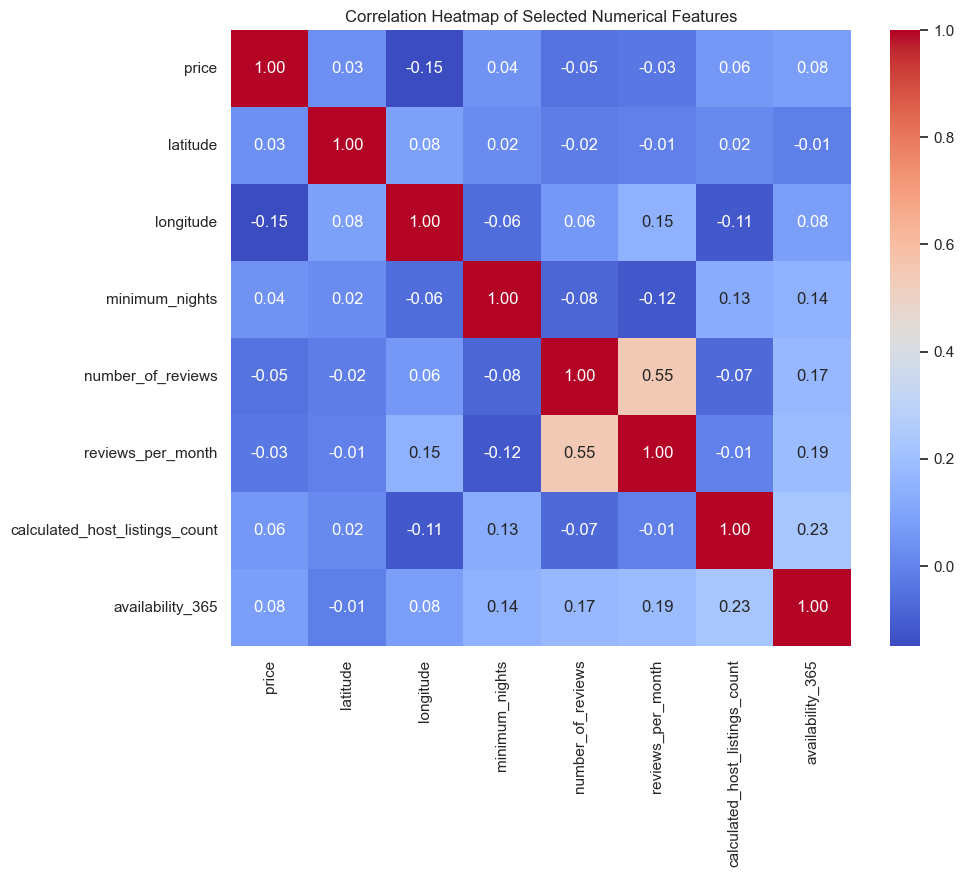

In [10]:
# Correlation heatmap
num_cols = [
    'price',
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

corr = bnb[num_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Selected Numerical Features')
plt.show()

# ==================
# Data Preprocessing
# ==================

In [11]:
bnb.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [12]:
columns_to_drop = ['id','host_id','name', 'host_name', 'last_review', 'reviews_per_month']
bnb.drop(columns=columns_to_drop, inplace=True)

In [13]:
bnb.shape

(48895, 10)

In [14]:
bnb.duplicated().sum()

0

In [15]:
# Define outlier removal function using IQR method
def remove_outliers_iqr(df, features):
    """
    Removes outliers from the specified features in the DataFrame using the IQR method.
    """
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        initial_count = len(df)
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
        final_count = len(df)
        print(f"Removed {initial_count - final_count} outliers from {feature}")
    return df

In [16]:
bnb = remove_outliers_iqr(bnb, ['price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365'])

Removed 2972 outliers from price
Removed 6185 outliers from minimum_nights
Removed 4536 outliers from number_of_reviews
Removed 3198 outliers from calculated_host_listings_count
Removed 3321 outliers from availability_365


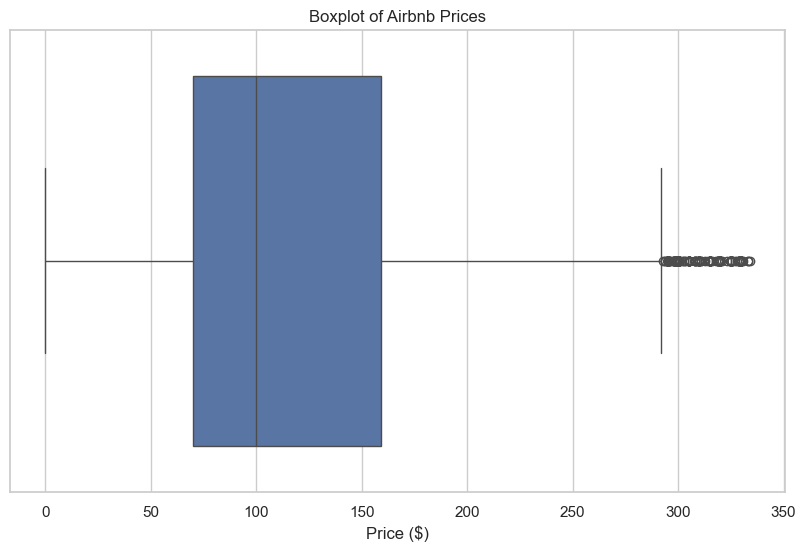

In [17]:
# Boxplot to detect outliers
plt.figure(figsize=(10,6))
sns.boxplot(x=bnb['price'])
plt.title('Boxplot of Airbnb Prices')
plt.xlabel('Price ($)')
plt.show()

In [18]:
bnb.shape

(28683, 10)

In [19]:
# Encode categorical features
categorical_cols = [
    'neighbourhood_group','neighbourhood','room_type'
]


In [20]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    bnb[col] = le.fit_transform(bnb[col])
    label_encoders[col] = le

In [21]:
bnb

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
4,2,60,40.79851,-73.94399,0,80,10,9,1,0
10,2,197,40.80316,-73.96545,0,135,5,53,1,6
18,1,50,40.67592,-73.94694,0,99,3,53,1,21
19,2,60,40.79685,-73.94872,0,190,7,0,2,249
20,1,209,40.71842,-73.95718,0,299,3,9,1,0
...,...,...,...,...,...,...,...,...,...,...
48889,3,103,40.69137,-73.80844,1,65,1,0,2,163
48890,1,13,40.67853,-73.94995,1,70,2,0,2,9
48891,1,28,40.70184,-73.93317,1,40,4,0,2,36
48892,2,92,40.81475,-73.94867,0,115,10,0,1,27


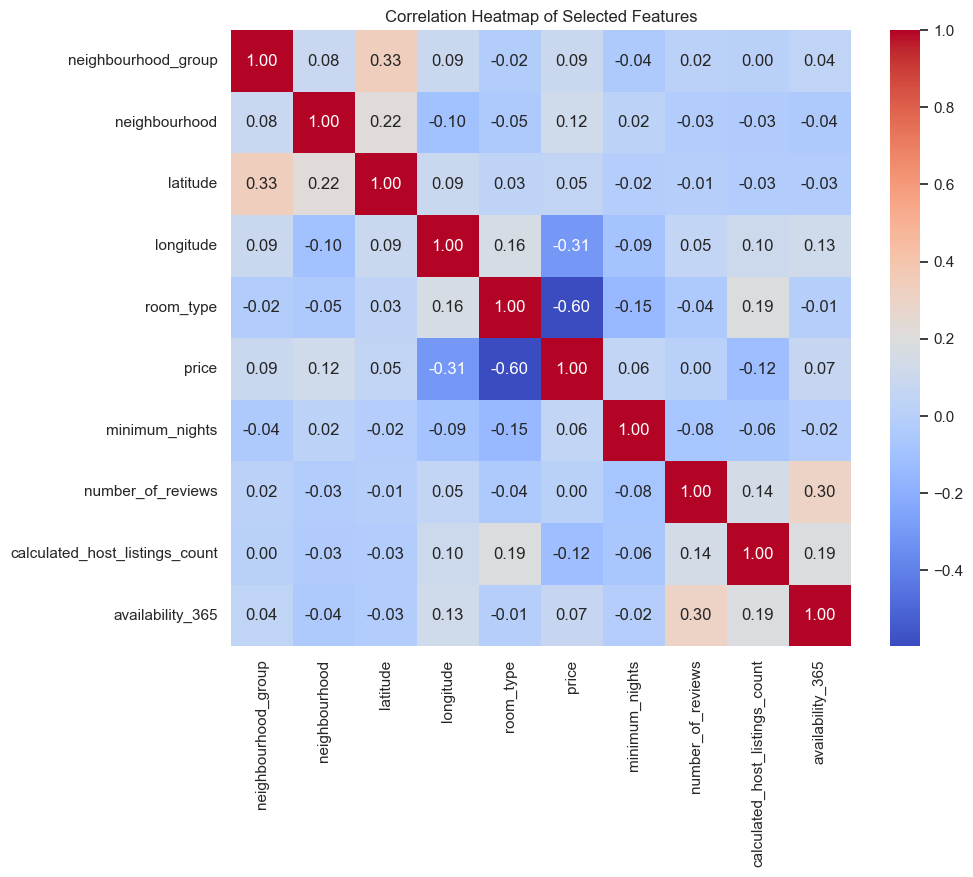

In [22]:
corr = bnb.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Selected Features')
plt.show()

In [23]:

# Define features and target
X = bnb.drop(['price'], axis=1, errors='ignore') 
y = bnb['price']

In [24]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [25]:
numeric_features = [
    'minimum_nights',
    'number_of_reviews',
    'calculated_host_listings_count',
    'availability_365',
    'longitude',
    'latitude'
]

# 3. Initialize and fit scaler only on training data
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])

X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [26]:
# List of models to evaluate
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso()),
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(objective='reg:squarederror', random_state=42))
]

# Initialize variables to track the best model
best_model_name = None
best_model_score = np.inf  # Lower MSE indicates better performance
best_model = None

# Dictionary to store evaluation results
results = {}

for name, model in models:
    # Train the model
    model.fit(X_train, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test)
    # Evaluate performance
    mse = mean_squared_error(y_test, y_pred)
    from sklearn.metrics import r2_score
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}
    print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")
    # Check if this is the best model so far
    if mse < best_model_score:
        best_model_score = mse
        best_model_name = name
        best_model = model

print(f"\nBest Model: {best_model_name} with MSE: {best_model_score:.4f}")


Linear Regression - MSE: 2462.3214, R2: 0.4284
Ridge Regression - MSE: 2462.3080, R2: 0.4284
Lasso Regression - MSE: 2465.5143, R2: 0.4276
Decision Tree - MSE: 4161.8991, R2: 0.0338
Random Forest - MSE: 2127.3662, R2: 0.5061
Gradient Boosting - MSE: 2012.2381, R2: 0.5328
XGBoost - MSE: 2094.5720, R2: 0.5137

Best Model: Gradient Boosting with MSE: 2012.2381


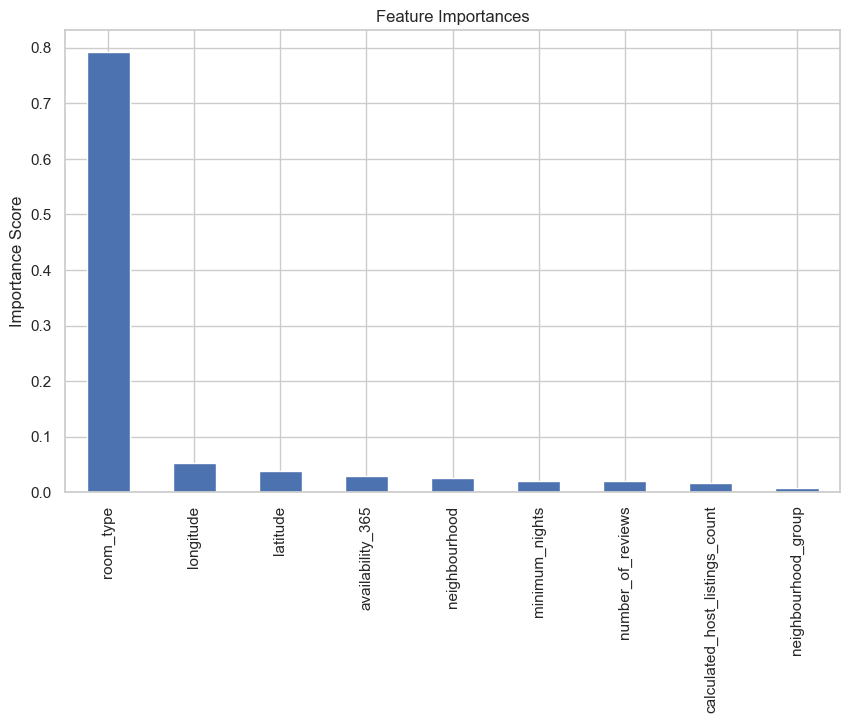

In [27]:
# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for visualization
feature_names = X_train.columns  # or list of feature names
feat_importances = pd.Series(importances, index=feature_names)

# Sort feature importances
feat_importances = feat_importances.sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(10,6))
feat_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.ylabel('Importance Score')
plt.show()

In [28]:
# =========================
# ADD THIS TO THE END OF YOUR TRAINING NOTEBOOK
# =========================

import joblib
import pickle

print("Starting model saving process...")

# 1. SAVE THE BEST MODEL
print(f"Best model: {best_model}")
print(f"Best model type: {type(best_model)}")

# Test the model first
test_sample = X_test.iloc[:1]  # Take first row
test_prediction = best_model.predict(test_sample)
print(f"Test prediction: {test_prediction}")

# Save the model
joblib.dump(best_model, 'model_clean.pkl')
print("✓ Model saved as 'model_clean.pkl'")

# Verify model loading
loaded_model = joblib.load('model_clean.pkl')
print(f"Loaded model type: {type(loaded_model)}")
verify_prediction = loaded_model.predict(test_sample)
print(f"Verify prediction: {verify_prediction}")

# 2. SAVE THE SCALER
print(f"\nScaler type: {type(scaler)}")
print(f"Numeric features that were scaled: {numeric_features}")

# Test scaler
test_numeric = X_test[numeric_features].iloc[:1]
scaled_test = scaler.transform(test_numeric)
print(f"Test scaling: {scaled_test}")

# Save scaler
joblib.dump(scaler, 'scaler_clean.pkl')
print("✓ Scaler saved as 'scaler_clean.pkl'")

# Verify scaler
loaded_scaler = joblib.load('scaler_clean.pkl')
verify_scaling = loaded_scaler.transform(test_numeric)
print(f"Verify scaling: {verify_scaling}")

# 3. SAVE LABEL ENCODERS
print(f"\nLabel encoders: {label_encoders}")
for col, encoder in label_encoders.items():
    print(f"{col} classes: {encoder.classes_}")

# Save encoders
joblib.dump(label_encoders, 'label_encoders_clean.pkl')
print("✓ Label encoders saved as 'label_encoders_clean.pkl'")

# Verify encoders
loaded_encoders = joblib.load('label_encoders_clean.pkl')
print(f"Loaded encoders keys: {list(loaded_encoders.keys())}")

# 4. SAVE FEATURE INFORMATION
feature_info = {
    'feature_names': list(X_train.columns),
    'numeric_features': numeric_features,
    'categorical_features': list(label_encoders.keys()),
    'n_features': X_train.shape[1]
}

joblib.dump(feature_info, 'feature_info.pkl')
print("✓ Feature info saved as 'feature_info.pkl'")

print(f"\nFeature order in training data: {list(X_train.columns)}")
print("All models saved successfully!")
print("\nFiles created:")
print("- model_clean.pkl")
print("- scaler_clean.pkl") 
print("- label_encoders_clean.pkl")
print("- feature_info.pkl")

Starting model saving process...
Best model: GradientBoostingRegressor(random_state=42)
Best model type: <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Test prediction: [61.34734762]
✓ Model saved as 'model_clean.pkl'
Loaded model type: <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Verify prediction: [61.34734762]

Scaler type: <class 'sklearn.preprocessing._data.StandardScaler'>
Numeric features that were scaled: ['minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365', 'longitude', 'latitude']
Test scaling: [[-3.82550190e-01 -7.52941619e-01 -3.15100247e+00 -6.17023193e-01
   1.75789970e+03 -7.22740308e+02]]
✓ Scaler saved as 'scaler_clean.pkl'
Verify scaling: [[-3.82550190e-01 -7.52941619e-01 -3.15100247e+00 -6.17023193e-01
   1.75789970e+03 -7.22740308e+02]]

Label encoders: {'neighbourhood_group': LabelEncoder(), 'neighbourhood': LabelEncoder(), 'room_type': LabelEncoder()}
neighbourhood_group classes: ['Bronx' 'Brooklyn' 'Ma